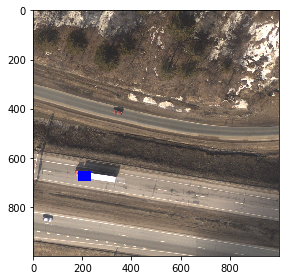

In [4]:
from skimage import transform, io, color, exposure
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.draw import rectangle, rectangle_perimeter

light_color = 255
dark_color = 50

# Функция создания признака Хаара
def haar_sign(w1=6, w2=4, w3=9, h=9, alpha=20, show_bit=0):
    #w1-w3 - ширина прямоугольников 1-3, h - высота прямоугольников,
    #alpha - угол наклона признака, show_bit=1 - бит разрешения отображения признака
    #Заполняем нулями прямоугольную область h*sum(w)
    img = np.zeros((h, w1+w2+w3), dtype=np.uint8)
    #создаем белый прямоугольник h*w1
    rr, cc = rectangle((0, 0), extent=(h, w1), shape=img.shape)
    img[rr, cc] = light_color
    #создаем черный прямоугольник h*w2
    rr, cc = rectangle((0, w1), extent=(h, w2), shape=img.shape)
    img[rr, cc] = dark_color
    #создаем белый прямоугольник h*w3
    rr, cc = rectangle((0, w1+w2), extent=(h, w3), shape=img.shape)
    img[rr, cc] = light_color
    # показываем полученный признак 
    io.imshow(img)
    io.show()
    # поворачиваем на угол alpha признак для детекции
    img = transform.rotate(img, 360-alpha, resize=True, preserve_range=False)
    #возвращаем матрицу признака, если не выставлен бит отображения
    if not show_bit:
        return img
    #img - матрица признака
    return img

# Функция создания входных данных,
def createDataset():
    dataset = []
    os.chdir("truck")
    img_list = os.listdir()
    for img in img_list:
        image = io.imread(img)
        # перевод в полутон
        img_gray = color.rgb2gray(image)
        # добавляем контраст изображению
        # (изображение, обрезание по сигма-функции, коэф. усиления, инверсия)
        img_contrast = exposure.adjust_sigmoid(img_gray, cutoff=0.5, gain=100, inv=False)
        # Создаём датасет с исходным и контрастным изображением
        dataset.append((image, img_contrast))
        
    os.chdir(os.getcwd() + "/../")
    # dataset - набор данных из пар (исходное изображение, чёрное-белое изображение)
    return dataset

# Функция детектирования изображения по признаку Хаара
def detection(img, haar_sign_img):
    # img - часть исходного изображения размером с признак
    # haar_sign_img - матрица признака
    # проверка размерности
    if img.shape != haar_sign_img.shape:
        print("Ошибка! Размеры не равны")
        raise IndexError
    # определяем порог изображения, с которым будем сравнивать характерный признак 50*N*M/255
    threshold = 42 * haar_sign_img.shape[0] * haar_sign_img.shape[1] / 255
    light, dark = 0, 0
    # сравниваем с признаками Хаара
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # если пиксель принадлежит белому прямоугольнику
            if haar_sign_img[x][y] == light_color/255:
                light += img[x][y]
            # если пиксель принадлежит черному прямоугольнику
            elif haar_sign_img[x][y] == dark_color/255:
                dark += img[x][y]
    # если разница превысила границу, то объект найден         
    if light - dark > threshold:
        # разница между суммами значений пикселей, входящих в белую и черную область
        return light - dark
    return -1

# Функция определения на картинке элементов, подходящих под признак Хаара
def pruning(img, haar_sign_img):
    # img - исходное ихображение, haar_sing_img - матрица признака
    coord = (-1, -1)
    max_value = -1
    size = haar_sign_img.shape
    for x in range(img.shape[0] - size[0]):
        for y in range(img.shape[1] - size[1]):
            # детектируем объект используя признак Хаара
            cur_value = detection(img[x:x+size[0], y:y+size[1]], haar_sign_img)
            if cur_value > max_value:
                max_value = cur_value
                coord = x, y 
    # coord - координаты объекта, max_val - максимальное значение
    return coord, max_value

# Функция отрисовки найденной области
def draw(img, coordinates, size):
    x, y = size
    # Если объект найден
    if coordinates != (-1, -1):
        rr, cc = rectangle(coordinates, extent=(x+30, y+30), shape=img.shape) 
        img[rr, cc] = (0, 0, 255) #синяя рамка
        
    io.imshow(img)
    io.show()


dataset = createDataset()
haarSign = haar_sign(w1=10,w2=5,w3=10, h=5, alpha=18, show_bit=1)
for n, image in enumerate(dataset):
        # ищем координаты в контрастном изображении
        coordinates, value = pruning(image[1], haarSign)
#         print("Coord = {}, diff = {}".format(coordinates, value))
        draw(image[0], coordinates, haarSign.shape)